<a href="https://colab.research.google.com/github/gloriankosi/notebooks/blob/main/heart_disease_uci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.kaggle.com/ronitf/heart-disease-uci
from google.colab import drive
drive.mount('/content/drive/')
% cd "/content/drive/My Drive/data-science"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data-science


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap
from sklearn import tree
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz


# age
# sex
# chest pain type (4 values)
# resting blood pressure
# serum cholestoral in mg/dl
# fasting blood sugar > 120 mg/dl
# resting electrocardiographic results (values 0,1,2)
# thalach = maximum heart rate achieved
# exercise induced angina
# oldpeak = ST depression induced by exercise relative to rest
# the slope of the peak exercise ST segment
# ca = number of major vessels (0-3) colored by flourosopy (i.e major vessels that can be seen)
# thal: (thalassemia) 3 = normal; 6 = fixed defect; 7 = reversable defect


### A look at the data

In [ ]:
data = pd.read_csv("heart.csv")
data.head(20)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


### Correlation Matrix

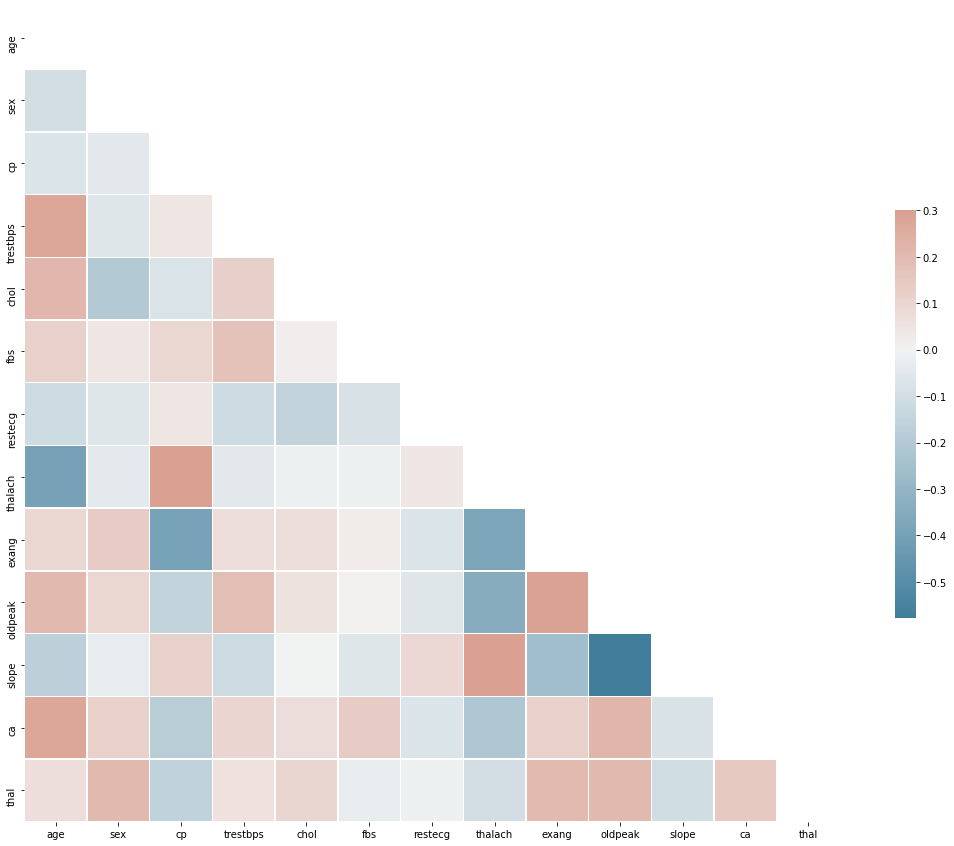

In [ ]:
corr = data.drop("target" , 1).corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
_=sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop("target" , 1) , data.target, test_size=.2)

## Comparisons between different models

### ***Using a Decision Tree Model***

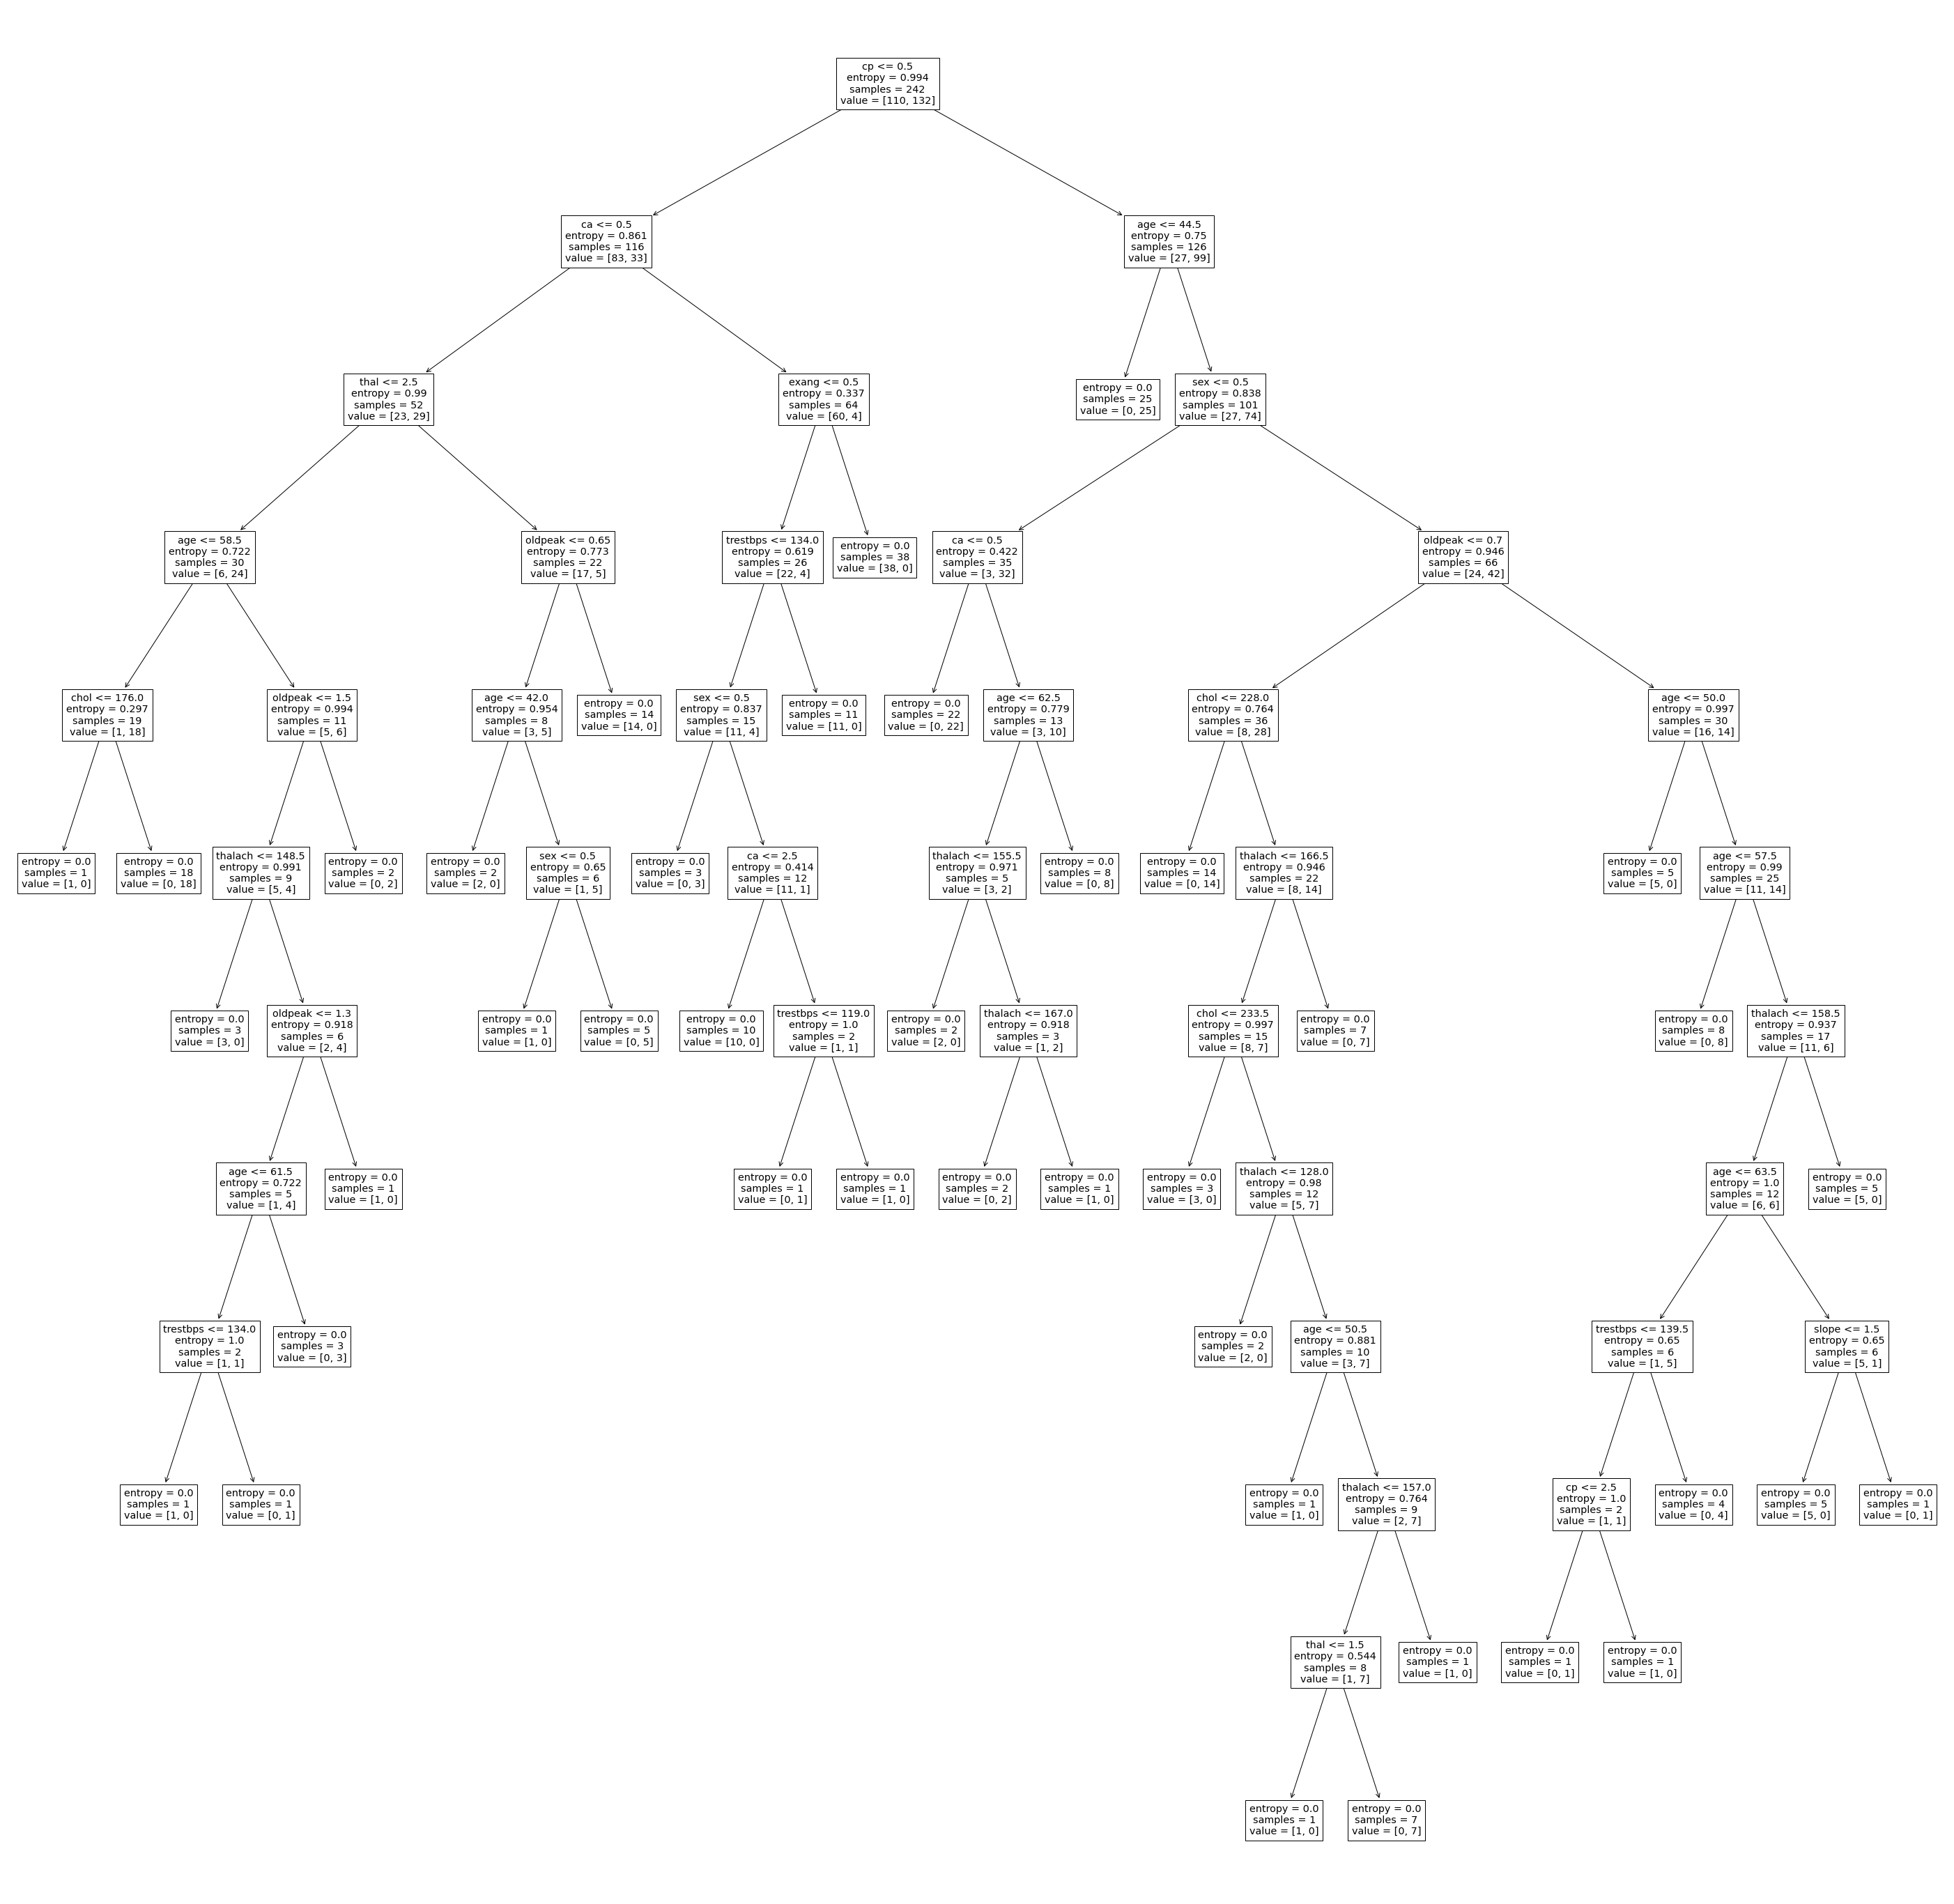

In [ ]:
plt.figure(figsize=(50,50))
model = DecisionTreeClassifier(criterion='entropy')
_ = model.fit(X_train, y_train)
_ = tree.plot_tree(model , feature_names=[x for x in data.columns])

#### Cross Validation

In [ ]:
print('10 fold')
scores = cross_val_score(model , X_test,y_test , cv=10 , scoring="accuracy") # cv=10
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
scores = cross_val_score(model , X_test,y_test , cv=10 , scoring="recall")
print("%0.3f recall with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
print('\n')

print('5 fold')
scores = cross_val_score(model , X_test,y_test , cv=5 , scoring="accuracy")# cv=5
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
scores = cross_val_score(model , X_test,y_test , cv=5 , scoring="recall")
print("%0.3f recall with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

10 fold
0.767 accuracy with a standard deviation of 0.170
0.842 recall with a standard deviation of 0.219


5 fold
0.787 accuracy with a standard deviation of 0.038
0.810 recall with a standard deviation of 0.156


#### Confusion Matrix

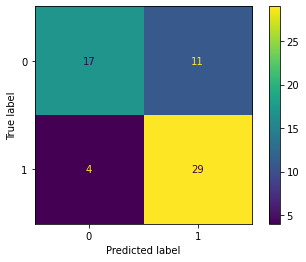

In [ ]:
y_pred_single_decision_tree=model.predict(X_test)
cm = confusion_matrix(y_test , y_pred_single_decision_tree)
_ = plot_confusion_matrix(model, X_test , y_test)

#### Confusion Matrix Reports

              precision    recall  f1-score   support

           0       0.81      0.61      0.69        28
           1       0.72      0.88      0.79        33

    accuracy                           0.75        61
   macro avg       0.77      0.74      0.74        61
weighted avg       0.76      0.75      0.75        61



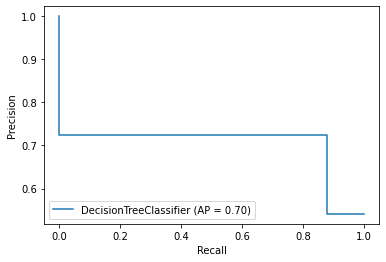

In [ ]:
# Precision = TruePositives / (TruePositives + FalsePositives)
# Recall = TruePositives / (TruePositives + FalseNegatives)
_ = plot_precision_recall_curve(model, X_test, y_test)
print(classification_report(y_test, y_pred_single_decision_tree))

#### Explanation

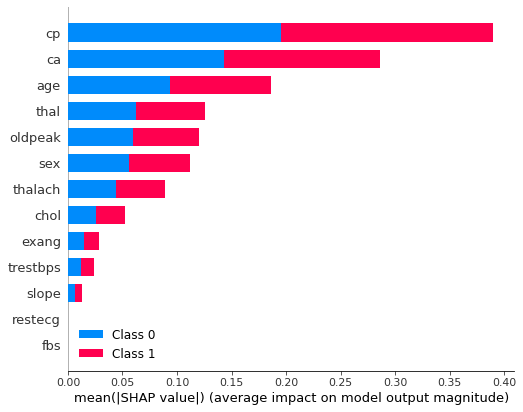

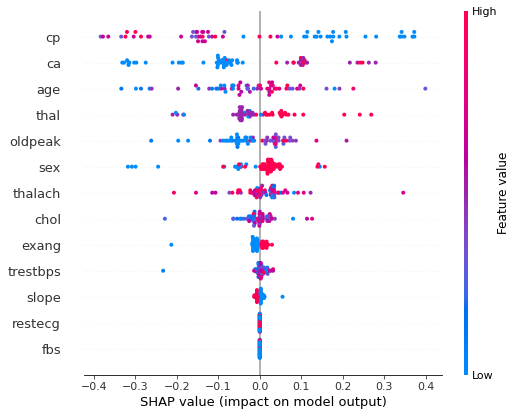

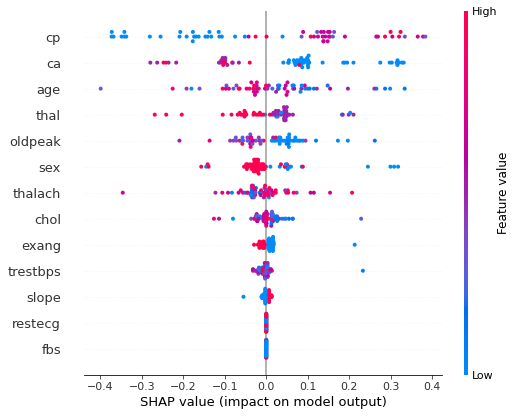

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test , y_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values[0], X_test)
shap.summary_plot(shap_values[1], X_test)

#### Dependence Plot for Predicted Heart Disease

In [ ]:
shap_values_ind = explainer.shap_values(X_test)

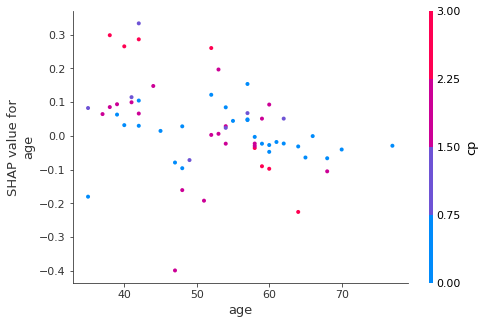

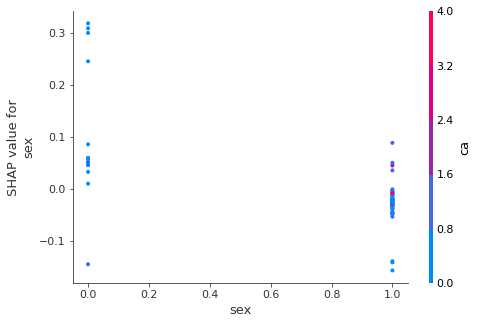

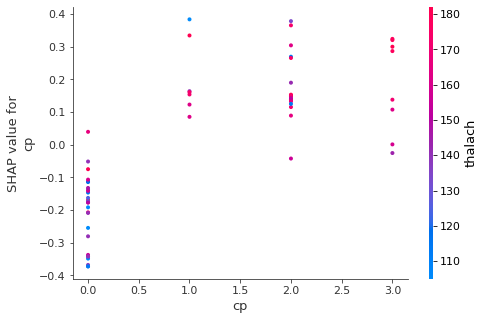

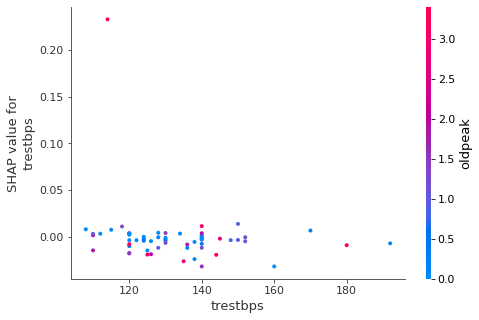

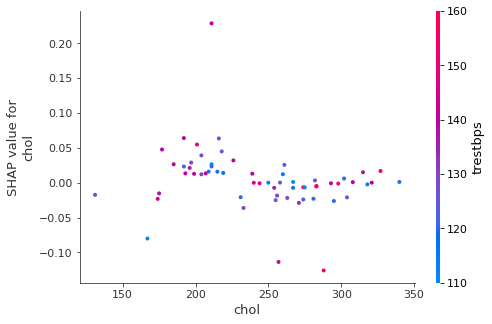

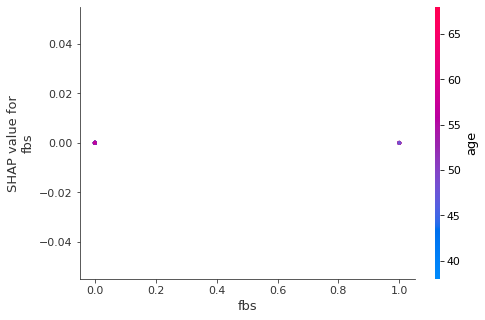

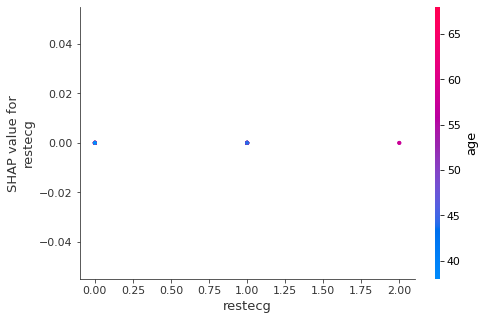

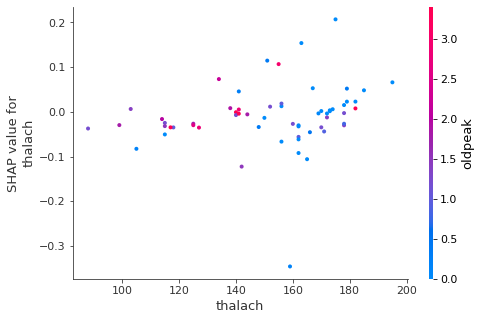

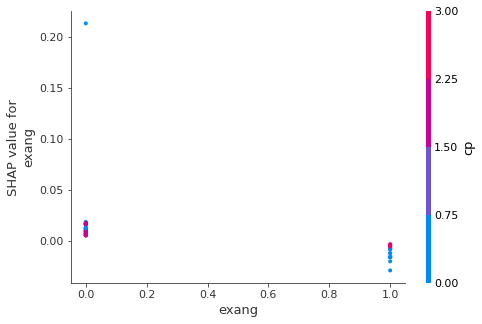

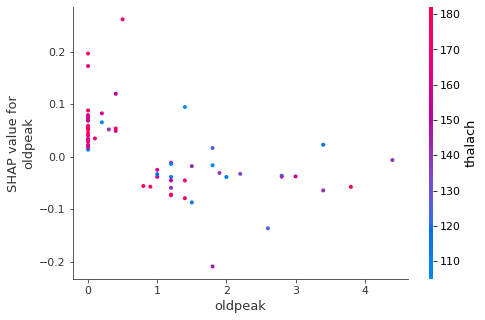

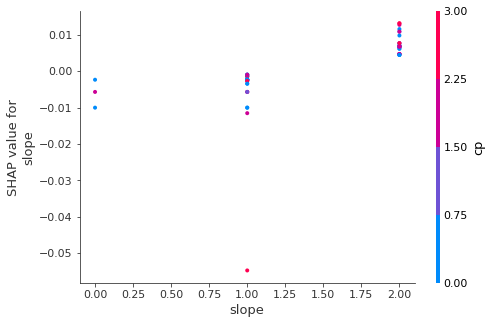

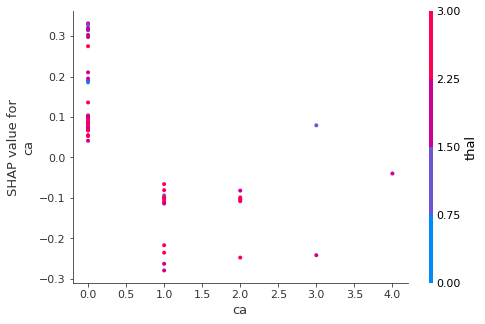

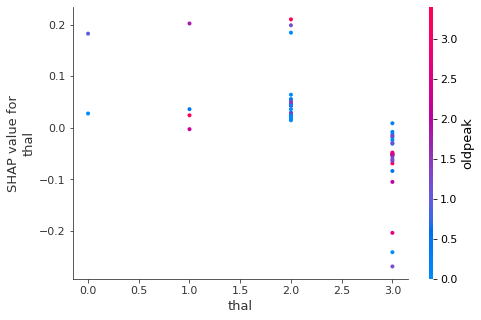

In [ ]:
for col in X_train.columns:
  shap.dependence_plot(col , shap_values_ind[1] , X_test)

#### Dependence Plot for predicted No Heart Disease

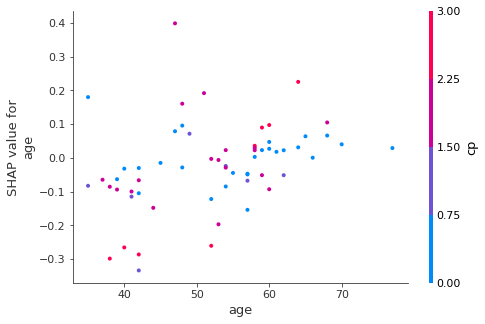

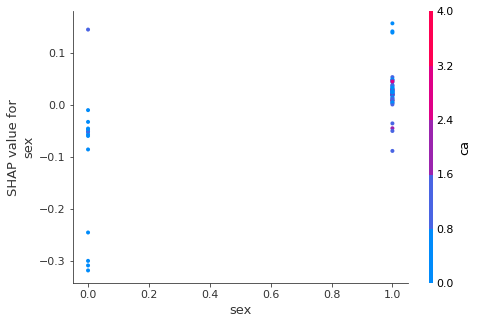

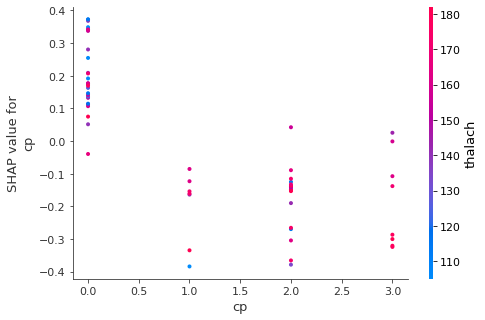

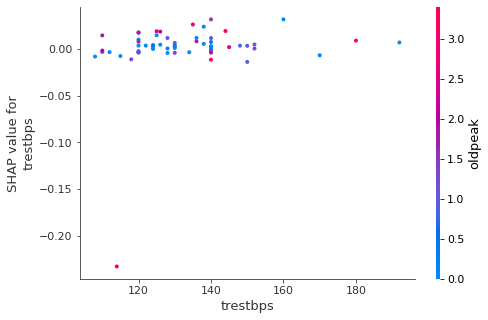

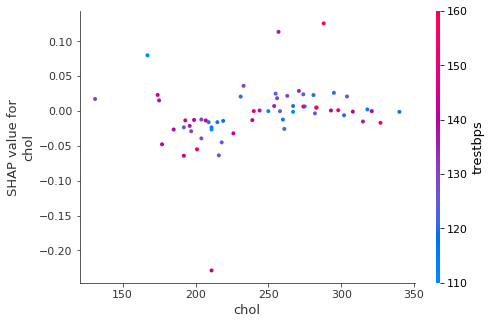

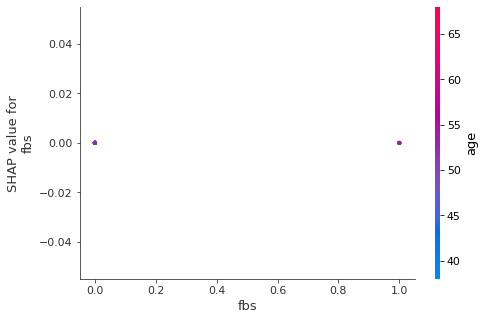

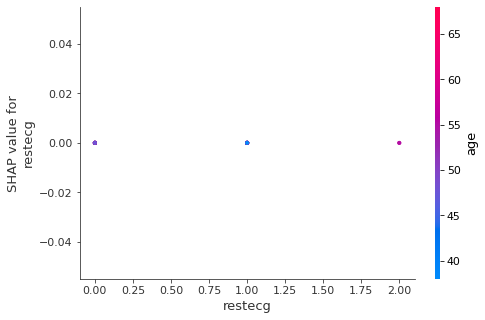

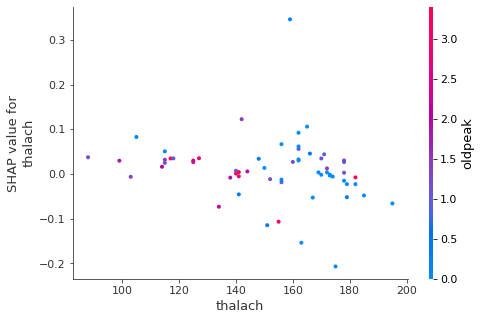

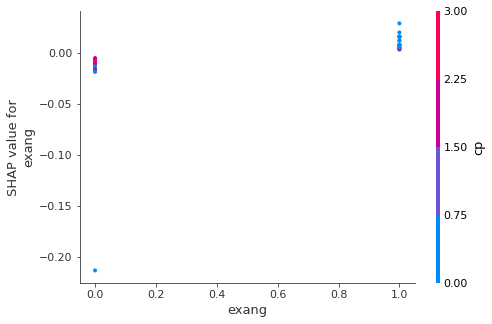

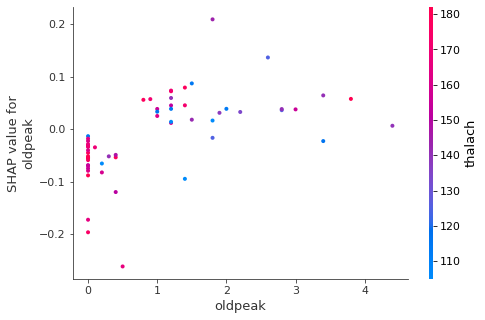

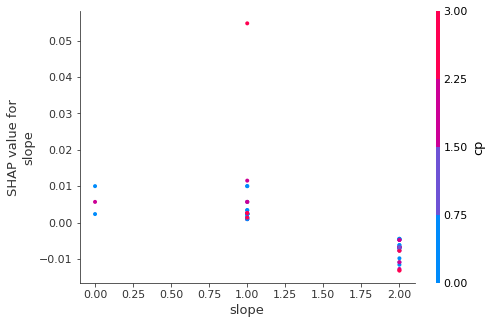

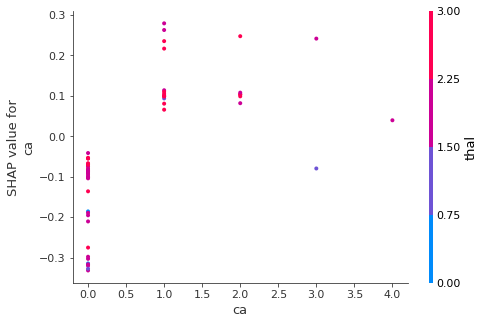

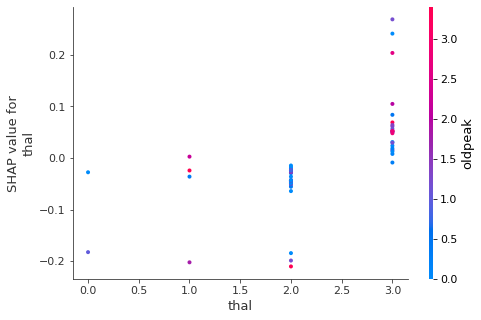

In [ ]:
for col in X_train.columns:
  shap.dependence_plot(col , shap_values_ind[0] , X_test)

#### *Conclusion*

---


For a Decision Tree Model, the number of major vessels colored by flourosopy (i.e 'ca' feature), chest pain level (i.e, 'cp' feature) and thalassemia (i.e 'thal' feature) tend to cause the greatest impact to predicting whether a patient is diagnosed with heart disease or not. Accuracy for a Decision Tree is not the best on either number of folds (5 or 10).

### ***Using a Random Forest Model***

In [ ]:
model = RandomForestClassifier(criterion='entropy' , n_estimators=500)
_ = model.fit(X_train, y_train)

#### Cross Validation

In [ ]:
print('10 fold')
scores = cross_val_score(model , X_test,y_test , cv=10 , scoring="accuracy") # cv=10
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
scores = cross_val_score(model , X_test,y_test , cv=10 , scoring="recall")
print("%0.3f recall with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
print('\n')

print('5 fold')
scores = cross_val_score(model , X_test,y_test , cv=5 , scoring="accuracy")# cv=5
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
scores = cross_val_score(model , X_test,y_test , cv=5 , scoring="recall")
print("%0.3f recall with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

10 fold
0.802 accuracy with a standard deviation of 0.146
0.817 recall with a standard deviation of 0.213


5 fold
0.787 accuracy with a standard deviation of 0.038
0.848 recall with a standard deviation of 0.139


#### Confusion Matrix

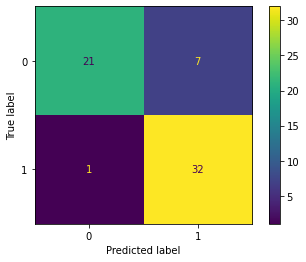

In [ ]:
y_pred_random_forest_tree=model.predict(X_test)
cm = confusion_matrix(y_test , y_pred_random_forest_tree)
_ = plot_confusion_matrix(model, X_test , y_test)

#### Confusion Matrix Reports

              precision    recall  f1-score   support

           0       0.95      0.75      0.84        28
           1       0.82      0.97      0.89        33

    accuracy                           0.87        61
   macro avg       0.89      0.86      0.86        61
weighted avg       0.88      0.87      0.87        61



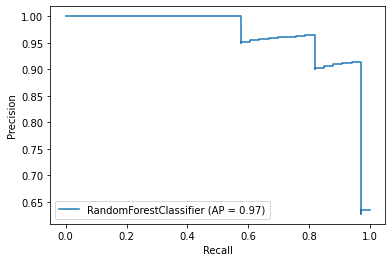

In [ ]:
# Precision = TruePositives / (TruePositives + FalsePositives)
# Recall = TruePositives / (TruePositives + FalseNegatives)
_ = plot_precision_recall_curve(model, X_test, y_test)
print(classification_report(y_test, y_pred_random_forest_tree))

#### Explanation

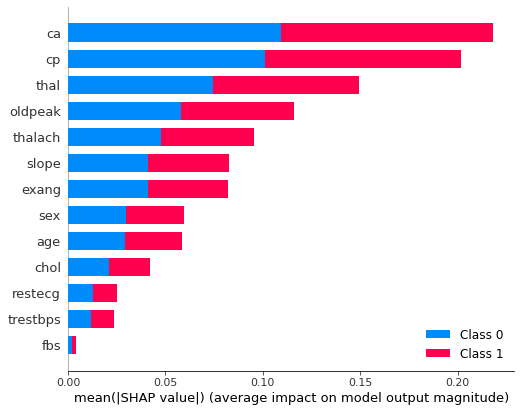

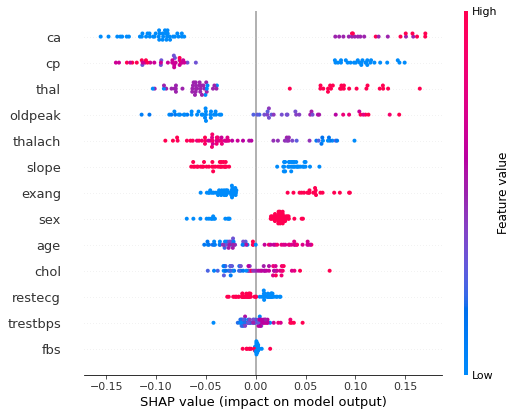

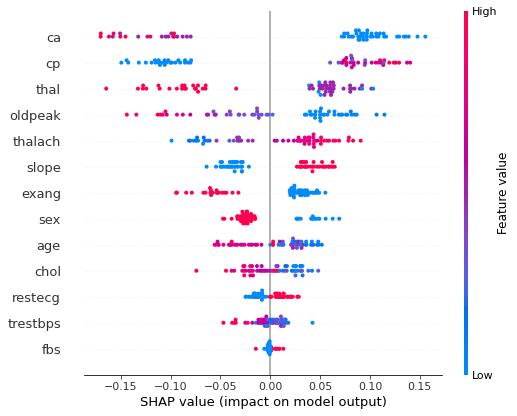

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test , y_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values[0], X_test)
shap.summary_plot(shap_values[1], X_test)

#### Dependence Plot for Predicted Heart Disease

In [ ]:
shap_values_ind = explainer.shap_values(X_test)

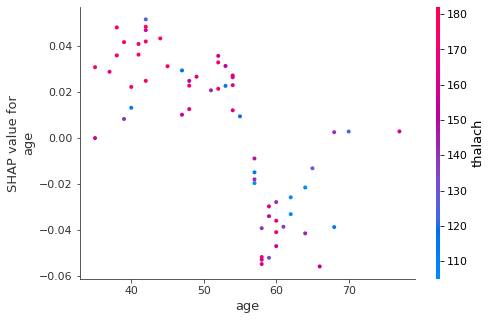

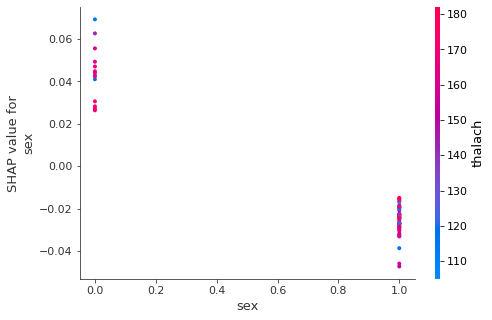

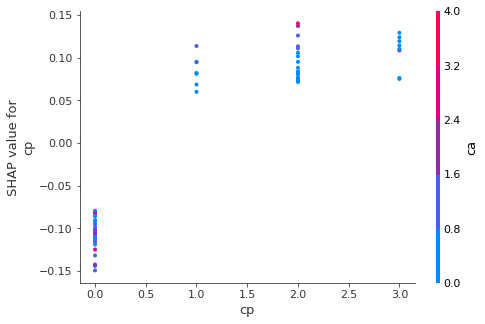

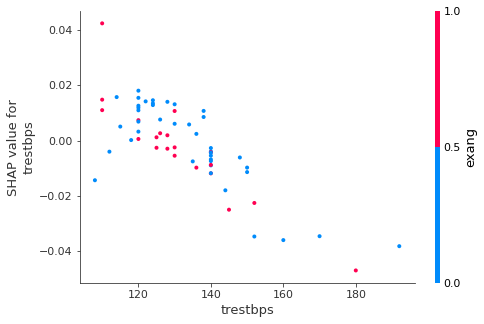

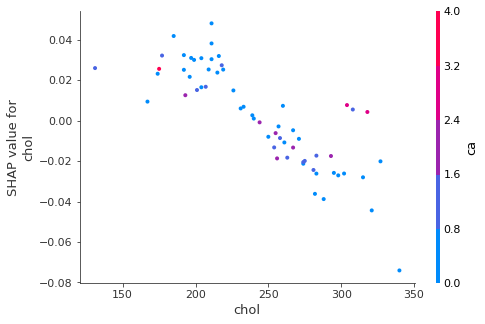

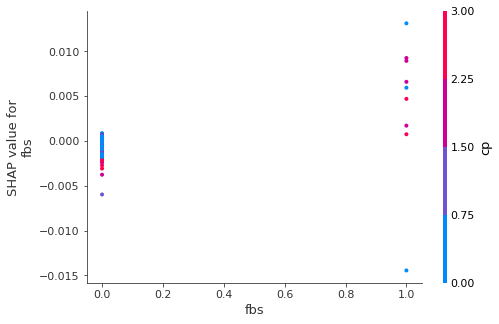

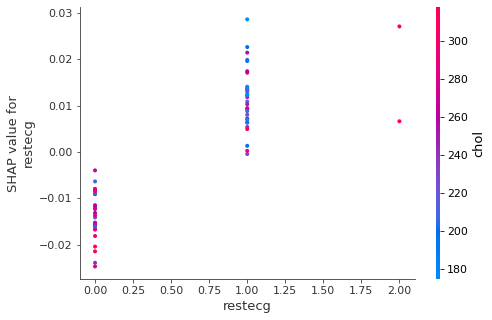

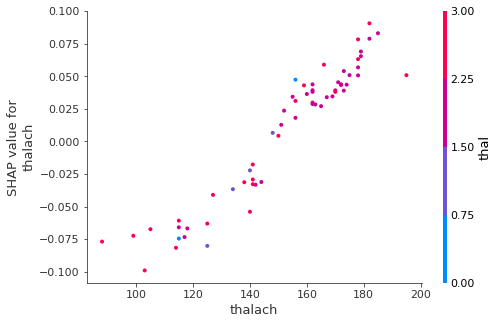

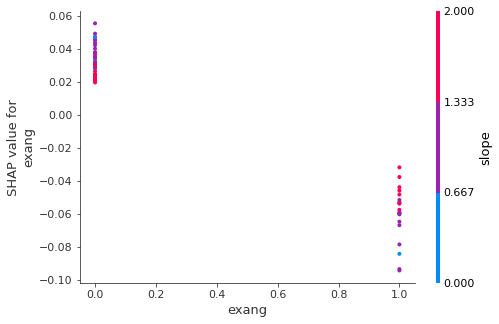

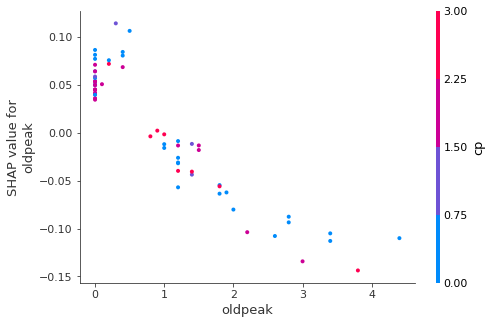

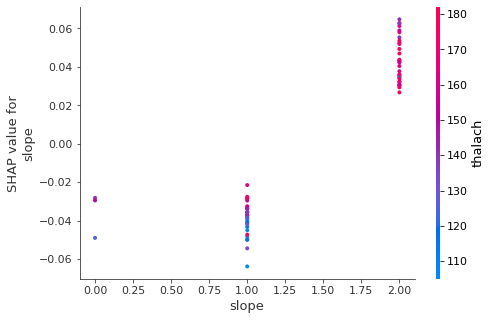

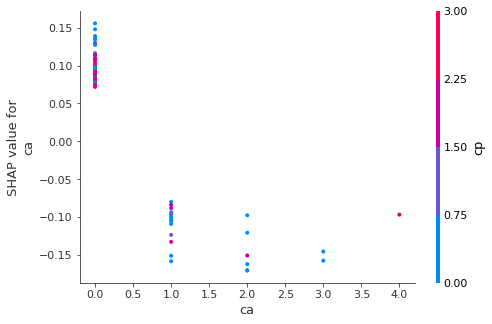

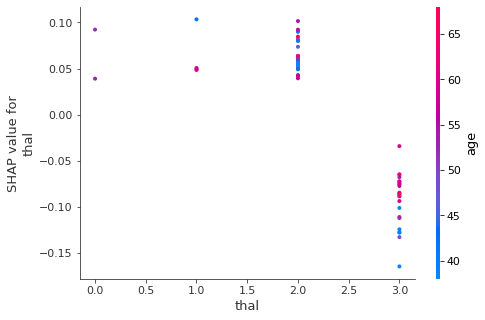

In [ ]:
for col in X_train.columns:
  shap.dependence_plot(col , shap_values_ind[1] , X_test)

#### Dependence Plot for predicted No Heart Disease

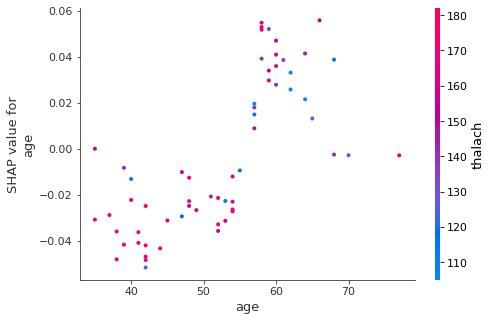

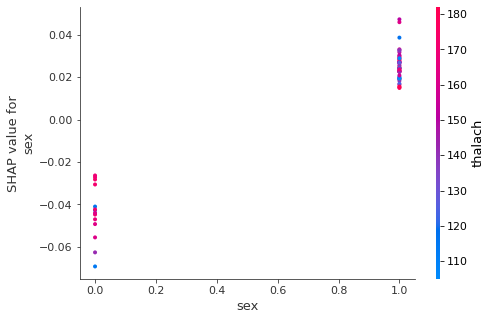

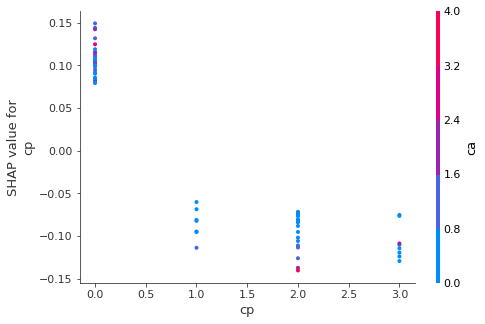

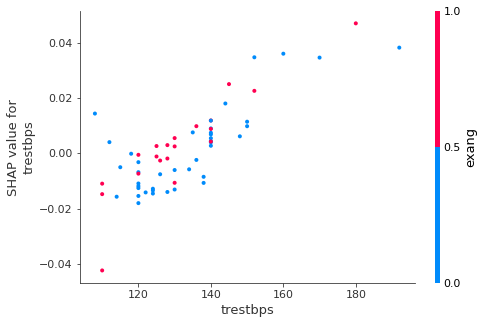

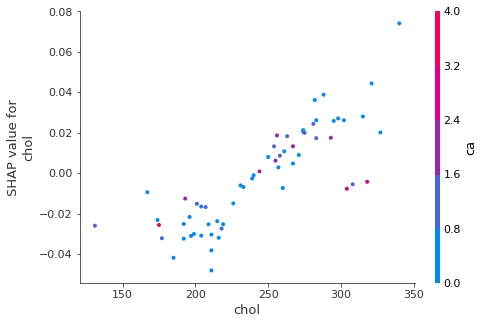

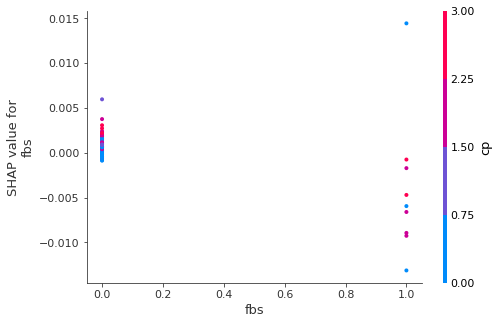

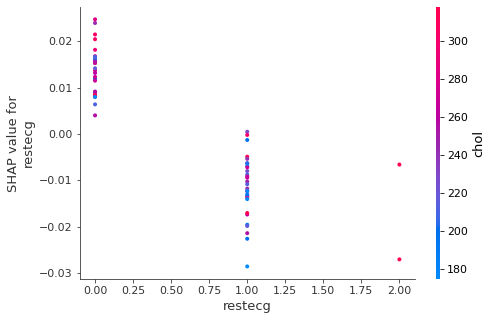

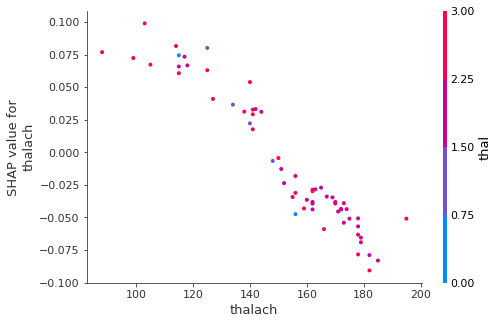

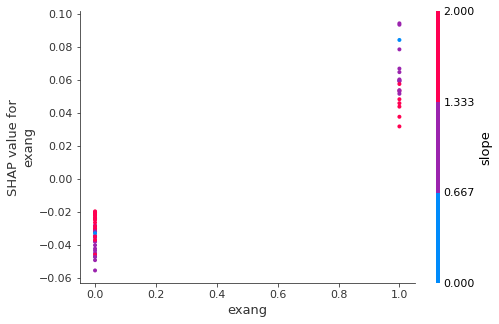

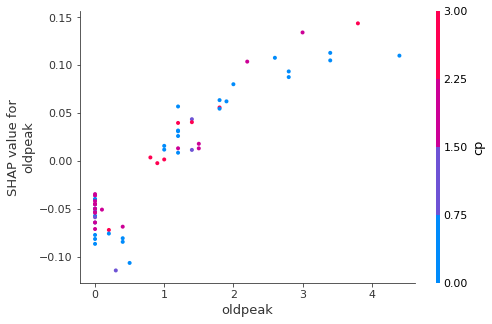

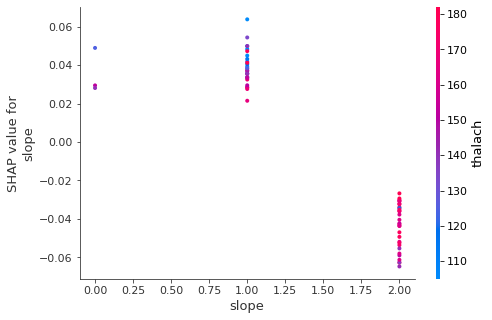

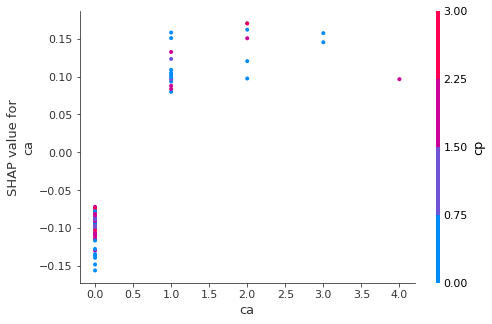

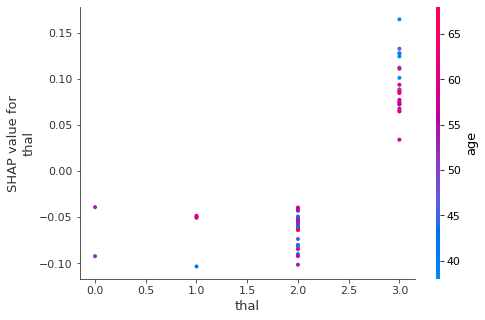

In [ ]:
for col in X_train.columns:
  shap.dependence_plot(col , shap_values_ind[0] , X_test)

#### *Conclusion* 

---

The most impactful features using a Random Forest Model are (like a Decision Tree Model), thal, ca, and cp. However, the recall, accuracy, and cross validation scores of a Random Forest Model tend to be moderately better than a Decision Tree Model.


### ***Using a Logistic Regression Model***

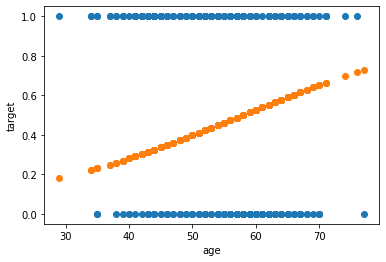

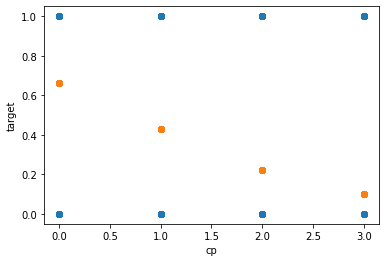

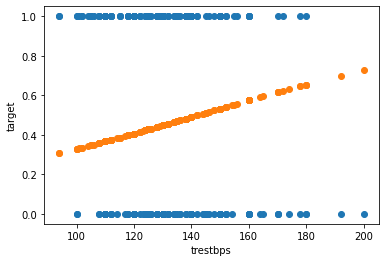

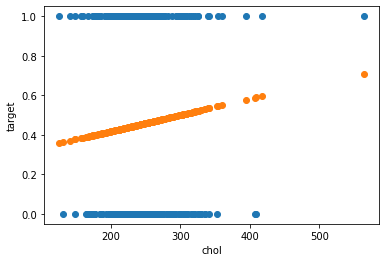

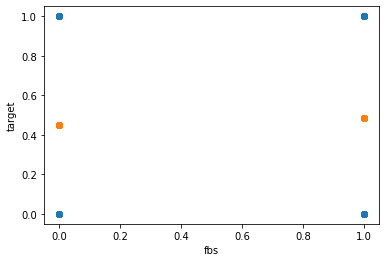

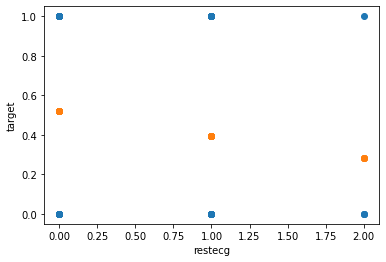

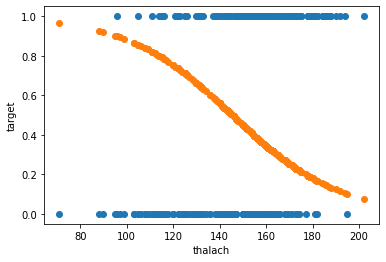

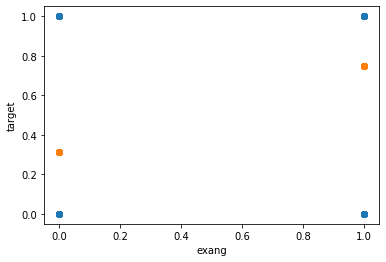

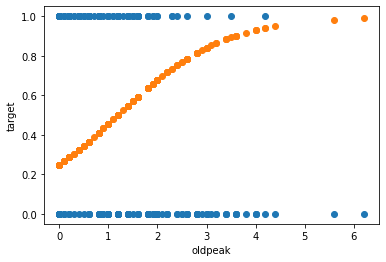

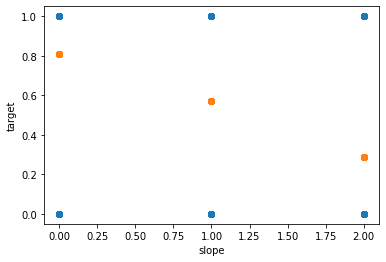

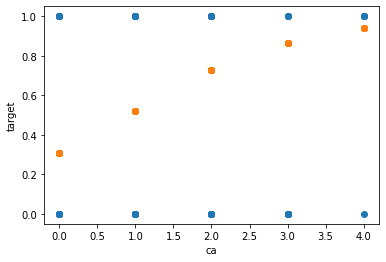

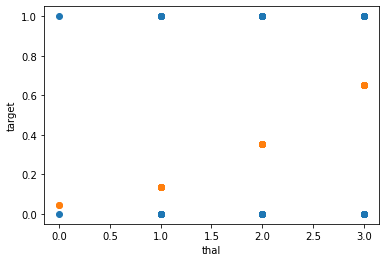

In [ ]:
for col in data.columns.drop(['target' , 'sex'] , 1):
  X = data[col].values.reshape(-1,1)
  Y = data['target'].values.reshape(-1,1)
  model = LogisticRegression(max_iter=1000).fit(X, np.ravel(Y.astype(float)))
  x_pred_proba = model.predict_proba(X)
  plt.xlabel(col)
  plt.ylabel('target')
  plt.scatter(X , Y)
  plt.scatter(X , x_pred_proba[:,0]) # plot each col probability of them NOT having heart disease 
  plt.show()

#### Cross Validation

In [ ]:
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)

In [ ]:
print('10 fold')
scores = cross_val_score(model , X_test,y_test , cv=10 , scoring="accuracy") # cv=10
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
scores = cross_val_score(model , X_test,y_test , cv=10 , scoring="recall")
print("%0.3f recall with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
print('\n')

print('5 fold')
scores = cross_val_score(model , X_test,y_test , cv=5 , scoring="accuracy")# cv=5
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))
scores = cross_val_score(model , X_test,y_test , cv=5 , scoring="recall")
print("%0.3f recall with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

10 fold
0.752 accuracy with a standard deviation of 0.202
0.817 recall with a standard deviation of 0.213


5 fold
0.753 accuracy with a standard deviation of 0.057
0.819 recall with a standard deviation of 0.105


#### Confusion Matrix

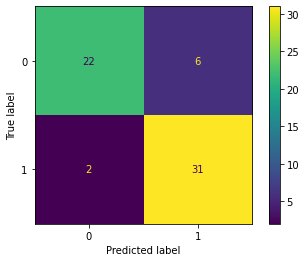

In [ ]:
y_pred_log_regression=model.predict(X_test)
_ = plot_confusion_matrix(model , X_test , y_test)

#### Confusion Matrix Reports

              precision    recall  f1-score   support

           0       0.92      0.79      0.85        28
           1       0.84      0.94      0.89        33

    accuracy                           0.87        61
   macro avg       0.88      0.86      0.87        61
weighted avg       0.87      0.87      0.87        61



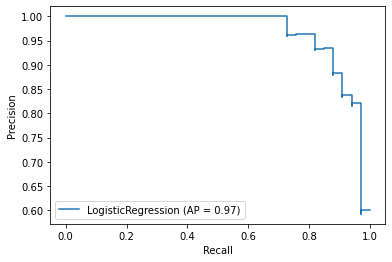

In [ ]:
_ = plot_precision_recall_curve(model, X_test, y_test)
print(classification_report(y_test, y_pred_log_regression))

#### Explanation

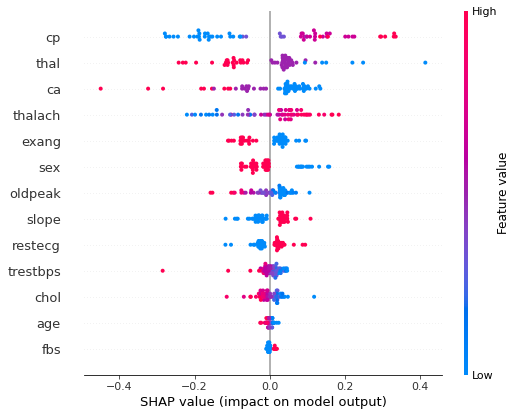

In [ ]:
shap.initjs()
model.fit(X_train , y_train)
explainer = shap.KernelExplainer(model.predict , X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

#### Dependence Plot for Predicted No Heart Disease

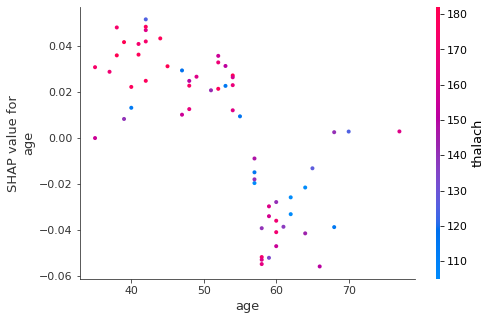

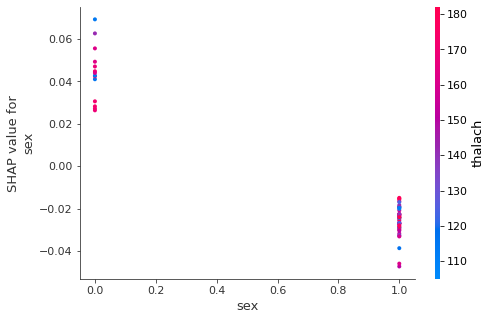

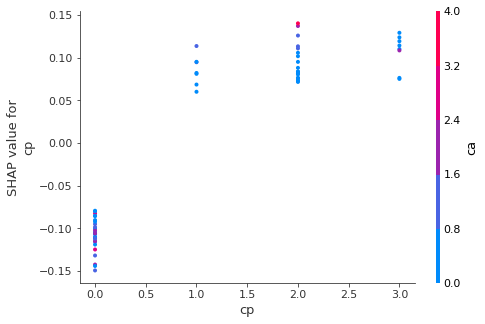

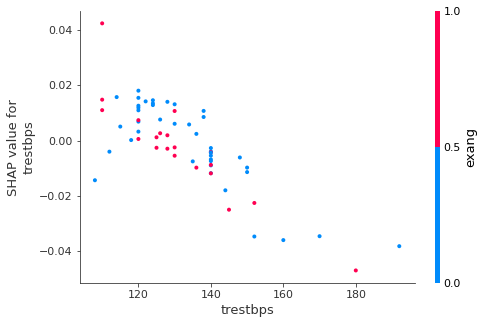

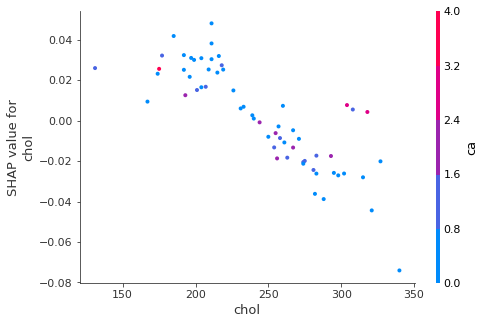

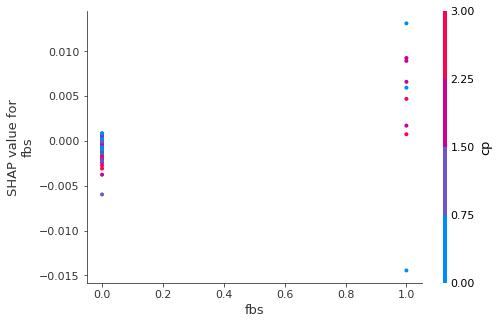

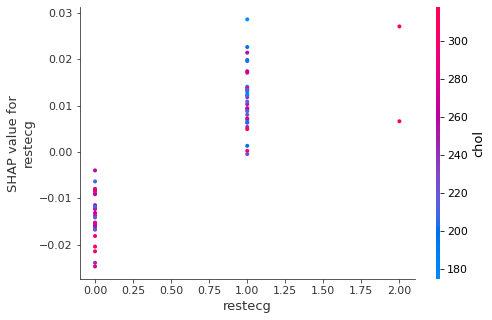

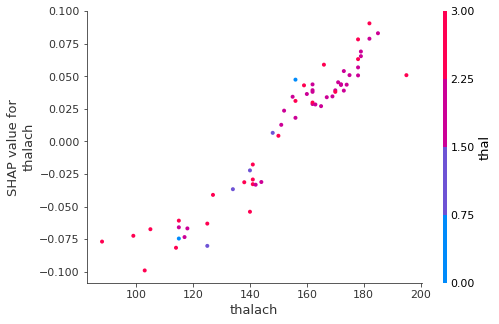

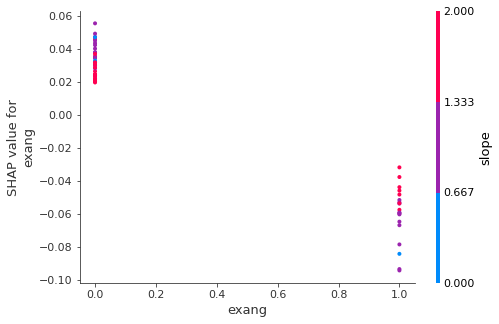

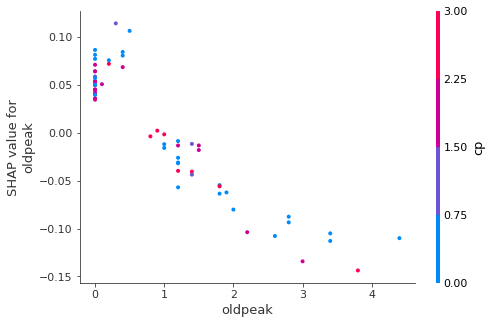

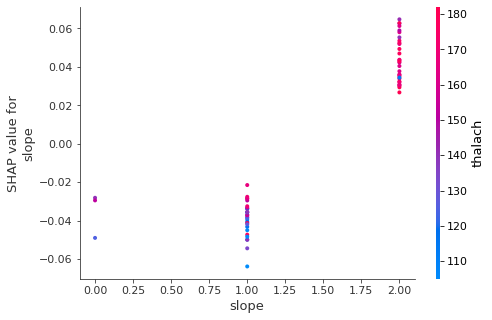

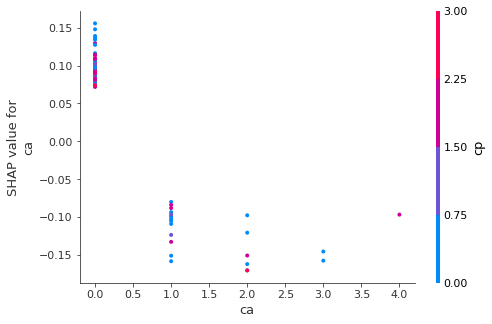

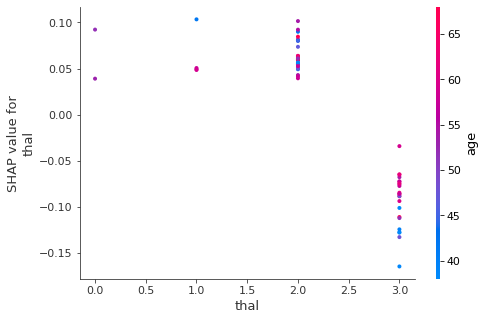

In [ ]:
for col in X_train.columns:
  shap.dependence_plot(col , shap_values_ind[1] , X_test)

#### Dependence Plot for Predicted Heart Disease

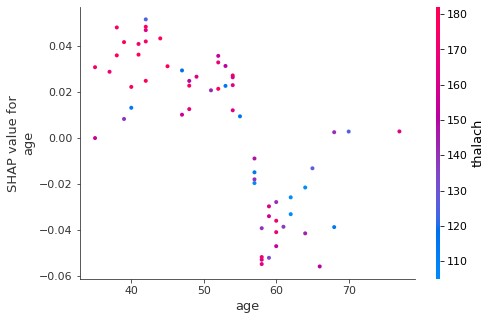

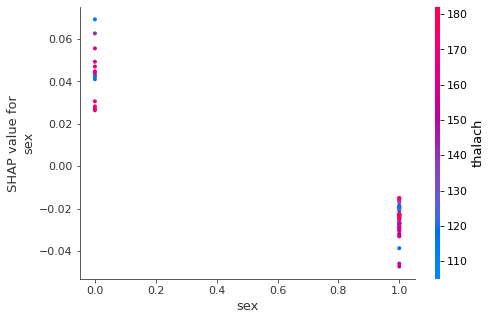

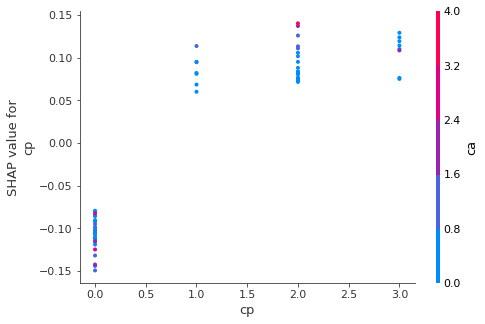

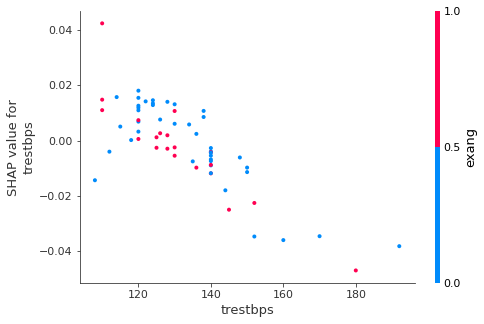

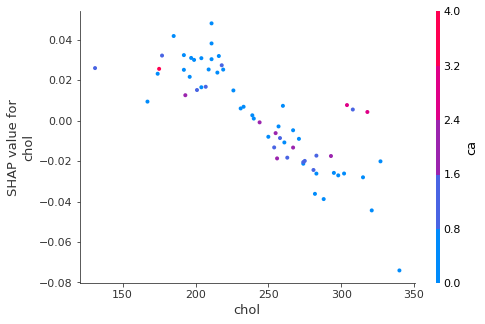

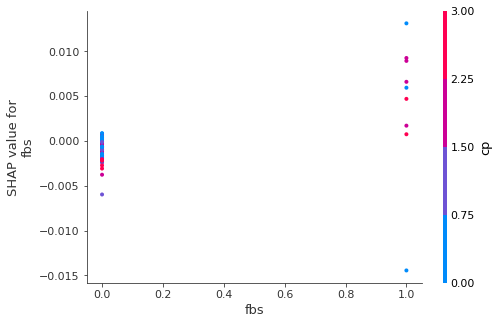

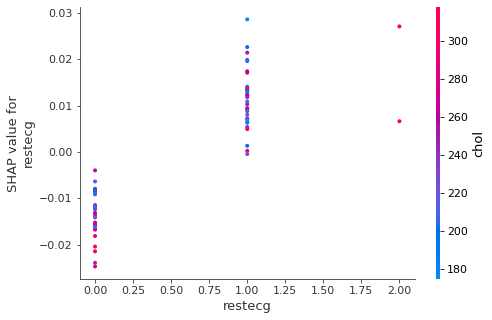

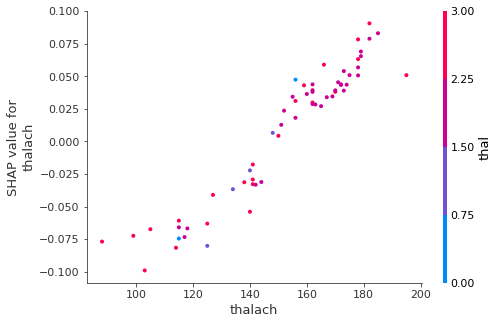

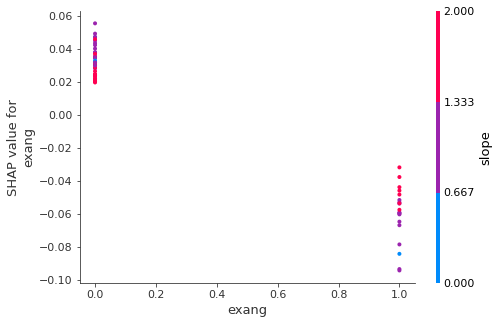

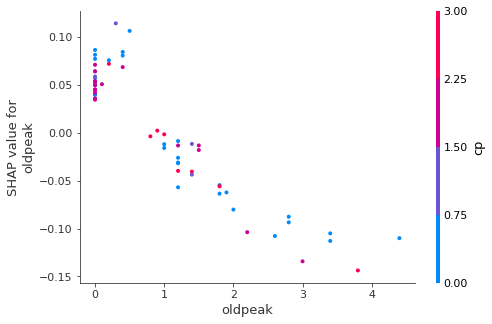

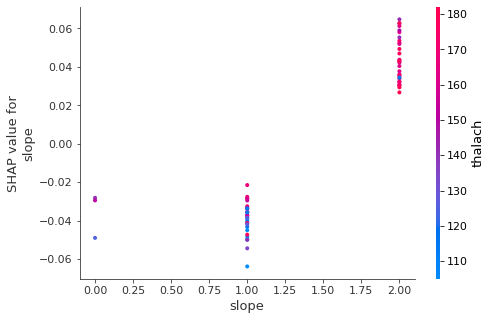

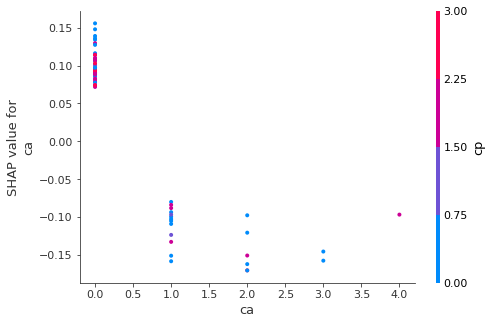

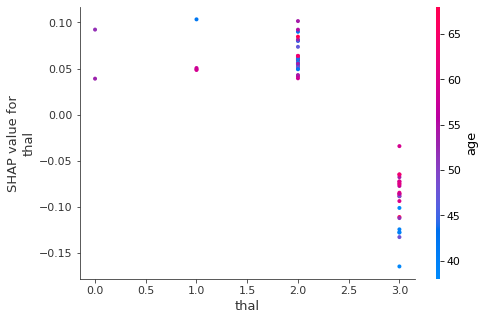

In [ ]:
for col in X_train.columns:
  shap.dependence_plot(col , shap_values_ind[1] , X_test)